# Usage examples of `swissparlpy`

In [ ]:
import swissparlpy as spp
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os
import urllib3
from datetime import datetime, timezone

In [ ]:
urllib3.disable_warnings()
__location__ = os.path.realpath(os.getcwd())

## Create client with custom session

Sometimes it's necessary to tweak the requests Session (e.g. to provide authentication or disable SSL verification).
For this purpose a custom session can be passed to `SwissParlClient`.

In [ ]:
session = requests.Session()
session.verify = False  # disable SSL verification
client = spp.SwissParlClient(session=session)

For most common cases, this is not necessary and you don't even have to create your own `SwissParlClient`.

Simply use the shorthand methods to get the data:

In [ ]:
tables = spp.get_tables()
glimpse_df = pd.DataFrame(spp.get_glimpse(tables[0]))
glimpse_df

## Get metadata of tables and variables

In [ ]:
client.get_tables()  # get list of all tables

In [ ]:
client.get_variables("Party")  # get list of variables of a table

## Load data in `pandas` DataFrame

In [ ]:
parties = client.get_data("Party", Language="DE")
parties_df = pd.DataFrame(parties)
parties_df

## Use substring operators to query data (`__startswith`, `__contains`)

In [ ]:
persons = client.get_data("Person", Language="DE", LastName__startswith="Bal")
persons.count

In [ ]:
person_df = pd.DataFrame(persons)
person_df

In [ ]:
co2_business = client.get_data("Business", Title__contains="CO2", Language="DE")
co2_business.count

In [ ]:
co2_df = pd.DataFrame(co2_business)
co2_df

## Query with date ranges

In [ ]:
utc_start_date = datetime.fromisoformat("2019-10-01").astimezone(timezone.utc)
utc_end_Date = datetime.fromisoformat("2019-10-31").astimezone(timezone.utc)
business_oct19 = client.get_data(
    "Business",
    Language="DE",
    SubmissionDate__gte=utc_start_date,
    SubmissionDate__lt=utc_end_Date,
)
business_oct19.count

In [ ]:
busi_oct19 = pd.DataFrame(business_oct19)
busi_oct19 = busi_oct19.sort_values(by=["SubmissionDate"]).reset_index(drop=True)
busi_oct19[["SubmissionDate", "Title"]]

## Download large query in batches

This script shows how to download votes from the `Voting` table by iterating over each session in a legislative period.
The chunks are then saved in a directory as pickled DataFrames.

Later on, those chunks can easily be combined together as a single DataFrame containing all the votes of a legislative period.

In [ ]:
path = os.path.join(__location__, "voting50")


def save_votes_of_session(id):
    if not os.path.exists(path):
        os.mkdir(path)
    pickle_path = os.path.join(path, f"{id}.pks")

    if os.path.exists(pickle_path):
        print(f"File {pickle_path} already exists, skipping")
        return

    print(f"Loading votes of session {id}...")
    data = client.get_data("Voting", Language="DE", IdSession=id)
    print(f"{data.count} rows loaded.")
    df = pd.DataFrame(data)

    df.to_pickle(pickle_path)
    print(f"Saved pickle at {pickle_path}")
    print("")


# get all session of the 50 legislative period
sessions50 = client.get_data("Session", Language="DE", LegislativePeriodNumber=50)
sessions50.count

for session in sessions50:
    print(f"Loading session {session['ID']}")
    save_votes_of_session(session["ID"])

# Combine to one dataframe
path = os.path.join(__location__, "voting50")
df_voting50 = pd.concat(
    [pd.read_pickle(os.path.join(path, x)) for x in os.listdir(path)]
)
df_voting50

In [ ]:
df_5005 = pd.read_pickle(os.path.join(__location__, "voting50", "5005.pks"))
df_5005

In [ ]:
# Combine to one dataframe
path = os.path.join(__location__, "voting50")
df_voting50 = pd.concat(
    [pd.read_pickle(os.path.join(path, x)) for x in os.listdir(path)]
)
df_voting50

## Queries with lots of results (server-side pagination)

There is a server-side limit of 1000 items that are being returned.
swissparlpy handles this server-side pagination transparently, so a user of the library should not worry about it.

In [ ]:
business = client.get_data("Business", Language="DE")
business.count

As we can see, there are over 50k results.
Initially only the first 1000 are loaded:

In [ ]:
len(business.data)

In [ ]:
business[1]

But as soon as a next element is accessed, new data is (lazy) loaded:

In [ ]:
business[1001]

In [ ]:
len(business.data)

If the last element is needed, all the data is loaded (NOTE: this uses quite some memory):

In [ ]:
business[-1]

In [ ]:
len(business.data)

## Visualize voting results

Get a vote result

In [ ]:
votes_df = spp.get_data("Voting", Language="DE", IdVote=31615).to_dataframe()
votes_df.tail()

Display the result as scoreboard

In [ ]:
fig = spp.plot_voting(votes_df, theme="scoreboard", result=True)
plt.show()

Or display the result in another theme and highlight a certain group

In [ ]:
fig = spp.plot_voting(
    votes_df, theme="poly1", highlight={"ParlGroupCode": ["S"]}, result=True
)
plt.show()

Get the data from Business to Vote to Voting to then display the plot:

In [ ]:
busi = spp.get_data(
    "Business",
    Language="DE",
    Title__contains="Industriestrategie der Schweiz. Die Wirtschaft stärken und die Widerstandsfähigkeit erhöhen",
)[0]
busi

In [44]:
votes = spp.get_data("Vote", Language="DE", BusinessNumber=busi["ID"])
voting = spp.get_data("Voting", Language="DE", IdVote=votes[0]["ID"]).to_dataframe()
voting = voting.sort_values(by="LastName").reset_index(drop=True)
voting.groupby("DecisionText")["ID"].count()

DecisionText
Die Präsidentin/der Präsident stimmt nicht     1
Enthaltung                                     9
Entschuldigt gemäss Art. 57 Abs. 4             2
Hat nicht teilgenommen                         6
Ja                                            98
Nein                                          84
Name: ID, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

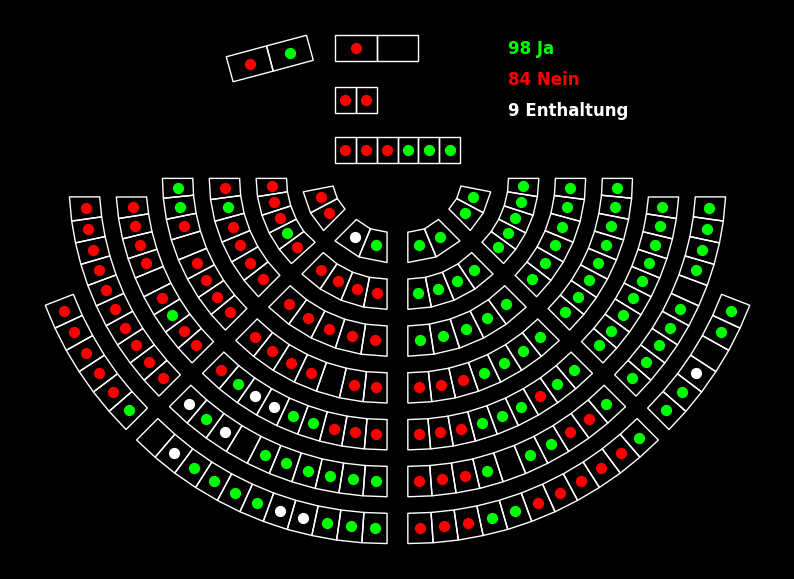

In [45]:
fig = spp.plot_voting(voting, theme="scoreboard", result=True)
plt.show